In [55]:
#1: Import Necessary Libraries
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image

In [56]:
#2: Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [65]:
#3: Load Data
TRAIN_DIR = 'C:/Users/dell/Face Exp/Images/train' 
TEST_DIR = 'C:/Users/dell/Face Exp/Images/test'    

In [66]:
#4: Data Transformations
transform = transforms.Compose([
    transforms.Grayscale(), 
    transforms.Resize((48, 48)),  
    transforms.ToTensor(), 
])

In [69]:
# 5. Load Datasets
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = datasets.ImageFolder(root=TEST_DIR, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [70]:
# 6. Define the CNN Model
class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 12 * 12, 256)  
        self.fc2 = nn.Linear(256, len(train_dataset.classes))  

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 64 * 12 * 12)  
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [71]:
# 7. Training Setup
model = EmotionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

In [47]:
# 8. Training the Model
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

train_model(model, train_loader, criterion, optimizer, num_epochs)

100%|██████████| 898/898 [01:09<00:00, 12.86it/s]


Epoch [1/10], Loss: 1.5456


100%|██████████| 898/898 [01:08<00:00, 13.16it/s]


Epoch [2/10], Loss: 1.3320


100%|██████████| 898/898 [01:02<00:00, 14.39it/s]


Epoch [3/10], Loss: 1.2150


100%|██████████| 898/898 [01:04<00:00, 13.96it/s]


Epoch [4/10], Loss: 1.1034


100%|██████████| 898/898 [01:07<00:00, 13.23it/s]


Epoch [5/10], Loss: 0.9900


100%|██████████| 898/898 [01:04<00:00, 13.90it/s]


Epoch [6/10], Loss: 0.8647


100%|██████████| 898/898 [01:01<00:00, 14.67it/s]


Epoch [7/10], Loss: 0.7301


100%|██████████| 898/898 [01:00<00:00, 14.92it/s]


Epoch [8/10], Loss: 0.5985


100%|██████████| 898/898 [01:02<00:00, 14.31it/s]


Epoch [9/10], Loss: 0.4709


100%|██████████| 898/898 [01:02<00:00, 14.29it/s]

Epoch [10/10], Loss: 0.3516


In [72]:
# 9. Save the Model
def save_model(model, filename):
    torch.save(model.state_dict(), filename)
    print(f"Model saved as '{filename}'")

save_model(model, 'emotion_cnn_model.pth')

Model saved as 'emotion_cnn_model.pth'


In [73]:
# 10. Evaluate the Model
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

all_labels, all_preds = evaluate_model(model, test_loader)

In [89]:
#11 Generate Classification Report and Confusion Matrix
report = classification_report(all_labels, all_preds, target_names=train_dataset.classes, zero_division=0)  
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.00      0.00      0.00      1024
       happy       0.00      0.00      0.00      1774
     neutral       0.22      0.02      0.03      1233
         sad       0.00      0.00      0.00      1247
    surprise       0.12      0.99      0.21       831

    accuracy                           0.12      7178
   macro avg       0.05      0.14      0.03      7178
weighted avg       0.05      0.12      0.03      7178



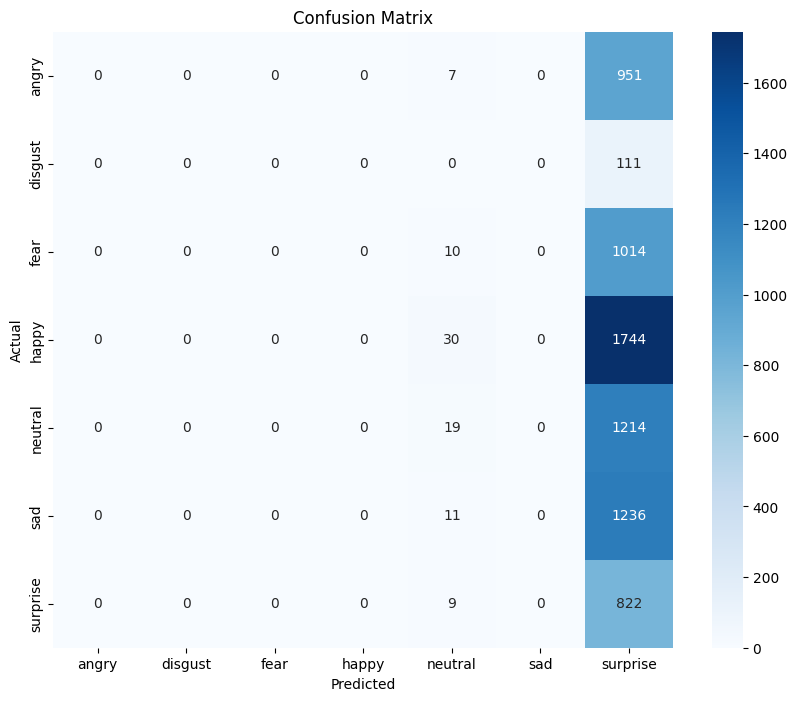

In [76]:
# 12. Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [77]:
# 13. Load the Model for Inference
loaded_model = EmotionCNN().to(device)
loaded_model.load_state_dict(torch.load('emotion_cnn_model.pth', weights_only=True))
loaded_model.eval()

EmotionCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=9216, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=7, bias=True)
)

In [78]:
# 14. Define a Function for Making Predictions
def predict_emotion(image_path):
    try:
        image = Image.open(image_path)
        image = transform(image).unsqueeze(0).to(device)  
        with torch.no_grad():
            output = loaded_model(image)
            _, predicted = torch.max(output, 1)
        return train_dataset.classes[predicted.item()]
    except Exception as e:
        print(f"Error in predicting emotion: {e}")
        return None

In [83]:
# 15. Example Predictions
example_images = [
    'C:/Users/dell/Face Exp/Images/test/angry/PrivateTest_731447.jpg',
    'C:/Users/dell/Face Exp/Images/test/disgust/PrivateTest_807646.jpg',
    'C:/Users/dell/Face Exp/Images/test/happy/PrivateTest_95094.jpg'
]

for path_to_image in example_images:
    predicted_emotion = predict_emotion(path_to_image)
    print(f'Predicted Emotion for {path_to_image}: {predicted_emotion}')

Predicted Emotion for C:/Users/dell/Face Exp/Images/test/angry/PrivateTest_731447.jpg: surprise
Predicted Emotion for C:/Users/dell/Face Exp/Images/test/disgust/PrivateTest_807646.jpg: surprise
Predicted Emotion for C:/Users/dell/Face Exp/Images/test/happy/PrivateTest_95094.jpg: surprise


In [84]:
# 16. Visualize Some Test Results
def visualize_predictions(test_loader, num_images=5):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].cpu().numpy().transpose(1, 2, 0), cmap='gray')
        plt.title(f'True: {train_dataset.classes[labels[i]]}\nPred: {train_dataset.classes[preds[i]]}')
        plt.axis('off')

    plt.show()

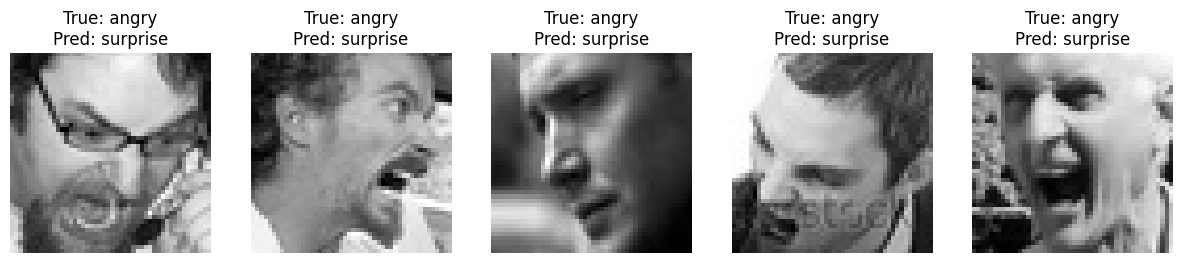

In [86]:
# 17. Visualize Predictions
visualize_predictions(test_loader)